In [1]:
import pandas as pd

# Load CpGs inside IRs
cpgs = pd.read_csv('cpgs_within_imprint_regions.csv', sep=',')

# Load IRs
irs = pd.read_csv("ICR_known_regions_hg38.csv", sep=",", header=0)

# Create a function to assign IR ID for each CpG
def assign_ir(row):
    for _, ir in irs.iterrows():
        if (row['Chr'] == ir['Chr']) and (row['Start'] >= ir['Start']) and (row['End'] <= ir['End']):
            return f"{ir['Chr']}:{ir['Start']}-{ir['End']}"
    return None

# Apply function - WARNING: This can be slow for large datasets
cpgs['IR_ID'] = cpgs.apply(assign_ir, axis=1)

In [2]:
# Drop CpGs not in any ME (if any)
cpgs = cpgs.dropna(subset=['IR_ID'])

cpgs = cpgs.drop_duplicates(subset=['Chr', 'Start', 'End', 'IR_ID'])

In [3]:
# Drop columns ending in '_cov' since we filtered in previous script
cov_cols = [col for col in cpgs.columns if col.endswith('_cov')]
cpgs = cpgs.drop(columns=cov_cols)

In [4]:
print(cpgs.columns)

Index(['Chr', 'Start', 'End', 'Naive_1_frac', 'Formative_1_frac',
       'Primed_1_frac', 'Formative_Neuron_1_frac', 'Primed_Neuron_1_frac',
       'Naive_2_frac', 'Formative_2_frac', 'Primed_2_frac',
       'Formative_Neuron_2_frac', 'Primed_Neuron_2_frac', 'IR_ID'],
      dtype='object')


In [5]:
# Define groups of columns to average
sample_groups = {
    'Naive_frac': ['Naive_1_frac', 'Naive_2_frac'],
    'Formative_frac': ['Formative_1_frac', 'Formative_2_frac'],
    'Primed_frac': ['Primed_1_frac', 'Primed_2_frac'],
    'Formative_Neuron_frac': ['Formative_Neuron_1_frac', 'Formative_Neuron_2_frac'],
    'Primed_Neuron_frac': ['Primed_Neuron_1_frac', 'Primed_Neuron_2_frac']
}

# Calculate row-wise mean for each group
for new_col, cols_to_avg in sample_groups.items():
    cpgs[new_col] = cpgs[cols_to_avg].mean(axis=1, skipna=True)

# Optionally: Drop the original replicate columns
cpgs = cpgs.drop(columns=[col for cols in sample_groups.values() for col in cols])

In [6]:
print(cpgs.head(10))

    Chr     Start       End                   IR_ID  Naive_frac  \
0  chr1  68050134  68050136  chr1:68050134-68050420      0.0665   
1  chr1  68050172  68050174  chr1:68050134-68050420      0.0415   
2  chr1  68050188  68050190  chr1:68050134-68050420      0.0835   
3  chr1  68050254  68050256  chr1:68050134-68050420      0.1940   
4  chr1  68050293  68050295  chr1:68050134-68050420      0.0920   
5  chr1  68050311  68050313  chr1:68050134-68050420      0.0500   
6  chr1  68050345  68050347  chr1:68050134-68050420      0.1020   
7  chr1  68050386  68050388  chr1:68050134-68050420      0.0000   
8  chr1  68050396  68050398  chr1:68050134-68050420      0.0000   
9  chr1  68050409  68050411  chr1:68050134-68050420      0.1265   

   Formative_frac  Primed_frac  Formative_Neuron_frac  Primed_Neuron_frac  
0          0.0280       0.4920                 0.1050              0.5240  
1          0.1380       0.6470                 0.2425              0.6070  
2          0.1815       0.6530    

In [7]:
ir_id = cpgs.pop('IR_ID')
cpgs['IR_ID'] = ir_id

In [8]:
print(cpgs.head(10))

    Chr     Start       End  Naive_frac  Formative_frac  Primed_frac  \
0  chr1  68050134  68050136      0.0665          0.0280       0.4920   
1  chr1  68050172  68050174      0.0415          0.1380       0.6470   
2  chr1  68050188  68050190      0.0835          0.1815       0.6530   
3  chr1  68050254  68050256      0.1940          0.2665       0.6925   
4  chr1  68050293  68050295      0.0920          0.3225       0.8465   
5  chr1  68050311  68050313      0.0500          0.0765       0.7010   
6  chr1  68050345  68050347      0.1020          0.0295       0.6635   
7  chr1  68050386  68050388      0.0000          0.1100       0.5950   
8  chr1  68050396  68050398      0.0000          0.0000       0.6230   
9  chr1  68050409  68050411      0.1265          0.1130       0.6080   

   Formative_Neuron_frac  Primed_Neuron_frac                   IR_ID  
0                 0.1050              0.5240  chr1:68050134-68050420  
1                 0.2425              0.6070  chr1:68050134-68050

In [9]:
# Save back if you want
cpgs.to_csv('cpgs_with_IR_ID.csv', sep=',', index=False)

/tmp/ipykernel_2726710/2140580281.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long, x='Sample', y='Methylation', palette='pastel', cut=0, inner='box')


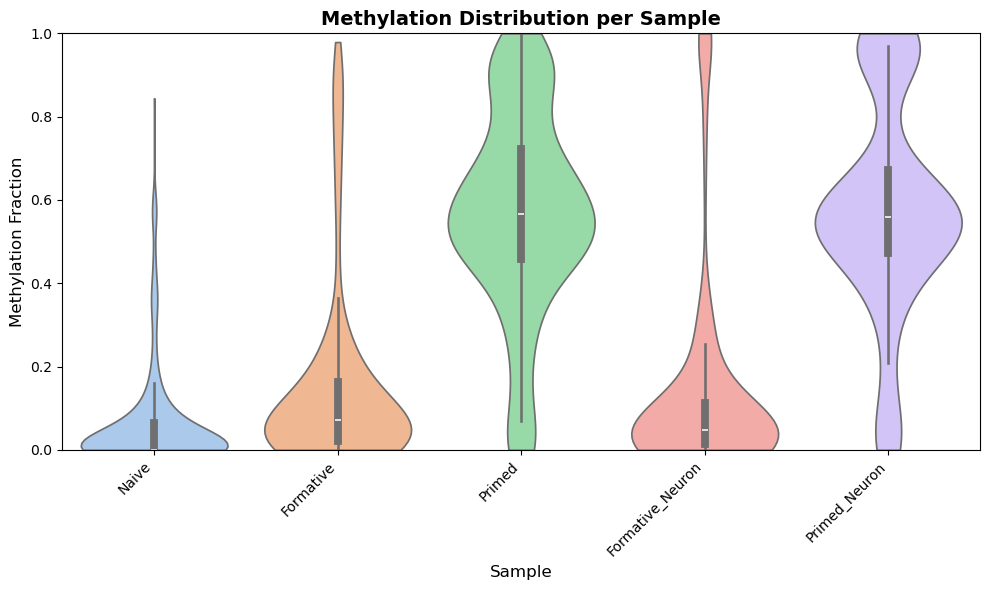

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#ensure meth frac distribution is what i expect

# === Load data ===
df = pd.read_csv("cpgs_with_IR_ID.csv", sep=",")

# === Select methylation fraction columns ===
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# === Melt dataframe to long format ===
df_long = df.melt(
    value_vars=frac_cols,
    var_name='Sample',
    value_name='Methylation'
)

# Drop missing values
df_long = df_long.dropna(subset=['Methylation'])

# Clean sample names (optional: remove "_frac" suffix)
df_long['Sample'] = df_long['Sample'].str.replace('_frac', '', regex=False)

# === Plot ===
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_long, x='Sample', y='Methylation', palette='pastel', cut=0, inner='box')

plt.title('Methylation Distribution per Sample', fontsize=14, weight='bold')
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Methylation Fraction', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()

# === Save ===
plt.savefig("methylation_violinplot_known_icrs.pdf", format='pdf', bbox_inches='tight')
plt.savefig("methylation_violinplot_known_icrs.svg", format='svg', bbox_inches='tight')
plt.show()